In [249]:
import pandas as pd
import psycopg2
import dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import warnings
from lifetimes import BetaGeoFitter

#### PUXANDO DADOS DA GCP

In [250]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

dotenv.load_dotenv()
# Configuração da conexão
config = {
    "host":     os.getenv("host_gcp"),
    "dbname":   "bibi",
    "user":     os.getenv("meuUser"),
    "password": os.getenv("minhaSenha"),
    "port":     os.getenv("port_gcp")
}

try:
    # Conectar ao banco e criar cursor
    conn = psycopg2.connect(**config)
    cursor = conn.cursor()
    print("Conectado!")

    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cursor.fetchall()
    print(tables)

    #Executar a query na tabela vendas
    query = "SELECT * FROM vendas;"
    cursor.execute(query)
    # Obter todas as linhas retornadas
    linhas = cursor.fetchall()
    # Obter os nomes das colunas a partir do cursor.description
    colunas = [desc[0] for desc in cursor.description]
    # Criar o DataFrame com os dados e as colunas
    df_vendas = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientes;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientePessoaFisica;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes_PF = pd.DataFrame(linhas, columns=colunas)
    
    #Exibir as primeiras linhas do DataFrame vendas e clientes
    print("TABLE VENDAS")
    print(df_vendas.head())
    
    print("\n\nTABLE CLIENTES")
    print(df_clientes.head())

    print("\n\nTABLE CLIENTES_PF")
    print(df_clientes_PF.head())
    
    # Fechar cursor e conexão
    cursor.close()
    conn.close()
    print("fechando cursor e conn")
except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

Conectado!
[('clientepessoafisica',), ('clientepessoajuridica',), ('vendas',), ('lojasfisicas',), ('clientes',)]
TABLE VENDAS
   id_venda  id_cliente nome_eventual  data_venda total_venda  \
0         1          -1          None  2022-12-16         360   
1         2          -1          None  2022-12-10         105   
2         3          -1          None  2022-12-10          80   
3         4          -1          None  2022-12-09         194   
4         5          -1          None  2022-12-04        59.9   

             status  id_loja  
0  aberto:digitacao        1  
1  aberto:digitacao        1  
2  aberto:digitacao        1  
3  aberto:digitacao        1  
4  aberto:digitacao        1  


TABLE CLIENTES
   id_cliente tipo_cliente email       telefone logradouro cep_cliente cidade  \
0           1         None   NaN  '92984121567'        NaN         NaN    NaN   
1           2            F   NaN  '92993378699'        NaN         NaN    NaN   
2           3            F   NaN   48

#### ANÁLISE EXPLORATÓRIA VENDAS E CLIENTES

In [251]:
# 1. Quantos id_cliente únicos?
unique_clientes = df_vendas['id_cliente'].nunique()
print(f"Quantidade de id_cliente únicos: {unique_clientes}")

# 2. Análise exploratória sobre a receita utilizando total_venda
print("\nAnálise exploratória da receita (total_venda):")
print(df_vendas['total_venda'].describe())

Quantidade de id_cliente únicos: 7817

Análise exploratória da receita (total_venda):
count     173436
unique      3555
top           35
freq       13670
Name: total_venda, dtype: object


Quantidade de clientes únicos por tipo_cliente:
tipo_cliente
F    8342
J     215
Name: id_cliente, dtype: int64


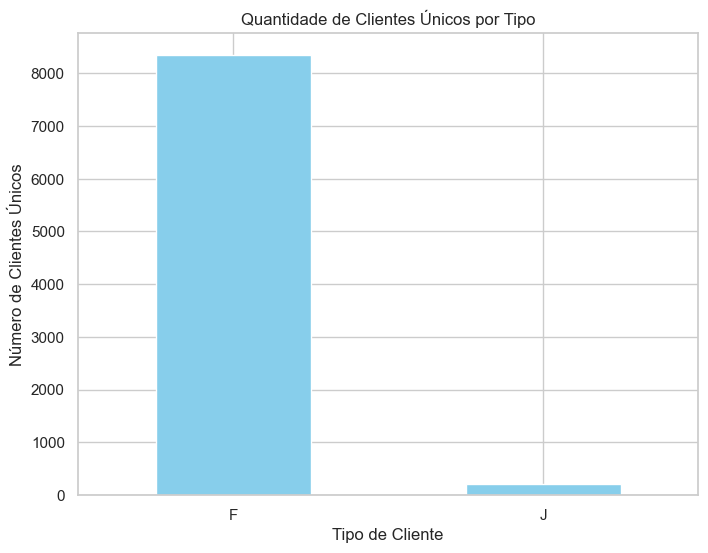

In [252]:
clientes_por_tipo = df_clientes.groupby('tipo_cliente')['id_cliente'].nunique()

print("Quantidade de clientes únicos por tipo_cliente:")
print(clientes_por_tipo)

# Opcional: Visualizando o resultado com um gráfico de barras
clientes_por_tipo.plot(kind='bar', color='skyblue', figsize=(8,6))
plt.title('Quantidade de Clientes Únicos por Tipo')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Número de Clientes Únicos')
plt.xticks(rotation=0)
plt.show()

#### ADICIONAR COLUNA TIPO_CLIENTE NA BASE DE VENDAS E FILTRAR PARA TER SOMENTE PF

In [253]:
df_vendas = df_vendas.merge(df_clientes[['id_cliente', 'tipo_cliente']], on='id_cliente', how='left')
df_vendas = df_vendas[df_vendas['tipo_cliente'] == 'F']
df_vendas = df_vendas[df_vendas['status'] == 'confirmado:aprovado']

unique_clientes = df_vendas['id_cliente'].nunique()
print(f"Número de Clientes PF: {unique_clientes}")

Número de Clientes PF: 5489


#### CÁLCULO RFMA

In [259]:
# Recency: Número de dias desde a última compra
data_referencia = df_vendas['data_venda'].max()
recency = df_vendas.groupby('id_cliente')['data_venda'].max().apply(lambda x: (data_referencia - x).days)

# Frequency: Número de pedidos únicos por cliente
frequency = df_vendas.groupby('id_cliente')['id_venda'].nunique()

# Monetary: Valor total gasto
monetary = df_vendas.groupby('id_cliente')['total_venda'].sum()

# Age (Antiguidade): Dias desde a primeira compra
age = df_vendas.groupby('id_cliente')['data_venda'].min().apply(lambda x: (data_referencia - x).days)

# Combinar métricas em um único DataFrame
rfma = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary,
    'Age': age
})

# Resetar o índice para ter id_cliente como coluna
rfma = rfma.reset_index()

# Adicionar algumas verificações
print("\nEstatísticas das métricas RFMA:")
print("\nRecency (dias):")
print(rfma['Recency'].describe())
print("\nFrequency (número de pedidos):")
print(rfma['Frequency'].describe())
print("\nMonetary (valor total):")
print(rfma['Monetary'].describe())
print("\nAge (dias desde primeira compra):")
print(rfma['Age'].describe())

#Salvar o resultado em um arquivo CSV
# rfma.to_csv('RFMA_por_cliente.csv', index=False)

# Exibir o DataFrame RFMA
print("\nPrimeiras linhas do RFMA:")
print(rfma.head())

# Verificações adicionais
print("\nContagens de controle:")
print(f"Número total de clientes: {len(rfma)}")

# Verificação adicional para Age
print("\nVerificação de coerência:")
print("Clientes com Age menor que Recency:", len(rfma[rfma['Age'] < rfma['Recency']]))


Estatísticas das métricas RFMA:

Recency (dias):
count    5489.000000
mean      708.839133
std       520.132824
min         0.000000
25%       246.000000
50%       629.000000
75%      1110.000000
max      1825.000000
Name: Recency, dtype: float64

Frequency (número de pedidos):
count    5489.000000
mean        1.353981
std         1.057323
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        24.000000
Name: Frequency, dtype: float64

Monetary (valor total):
count     5489
unique     853
top        300
freq       275
Name: Monetary, dtype: object

Age (dias desde primeira compra):
count    5489.000000
mean      777.707415
std       524.112922
min         0.000000
25%       309.000000
50%       713.000000
75%      1242.000000
max      1825.000000
Name: Age, dtype: float64

Primeiras linhas do RFMA:
   id_cliente  Recency  Frequency Monetary   Age
0           3      397          1      330   397
1           4     1321          1      250  1321
2 

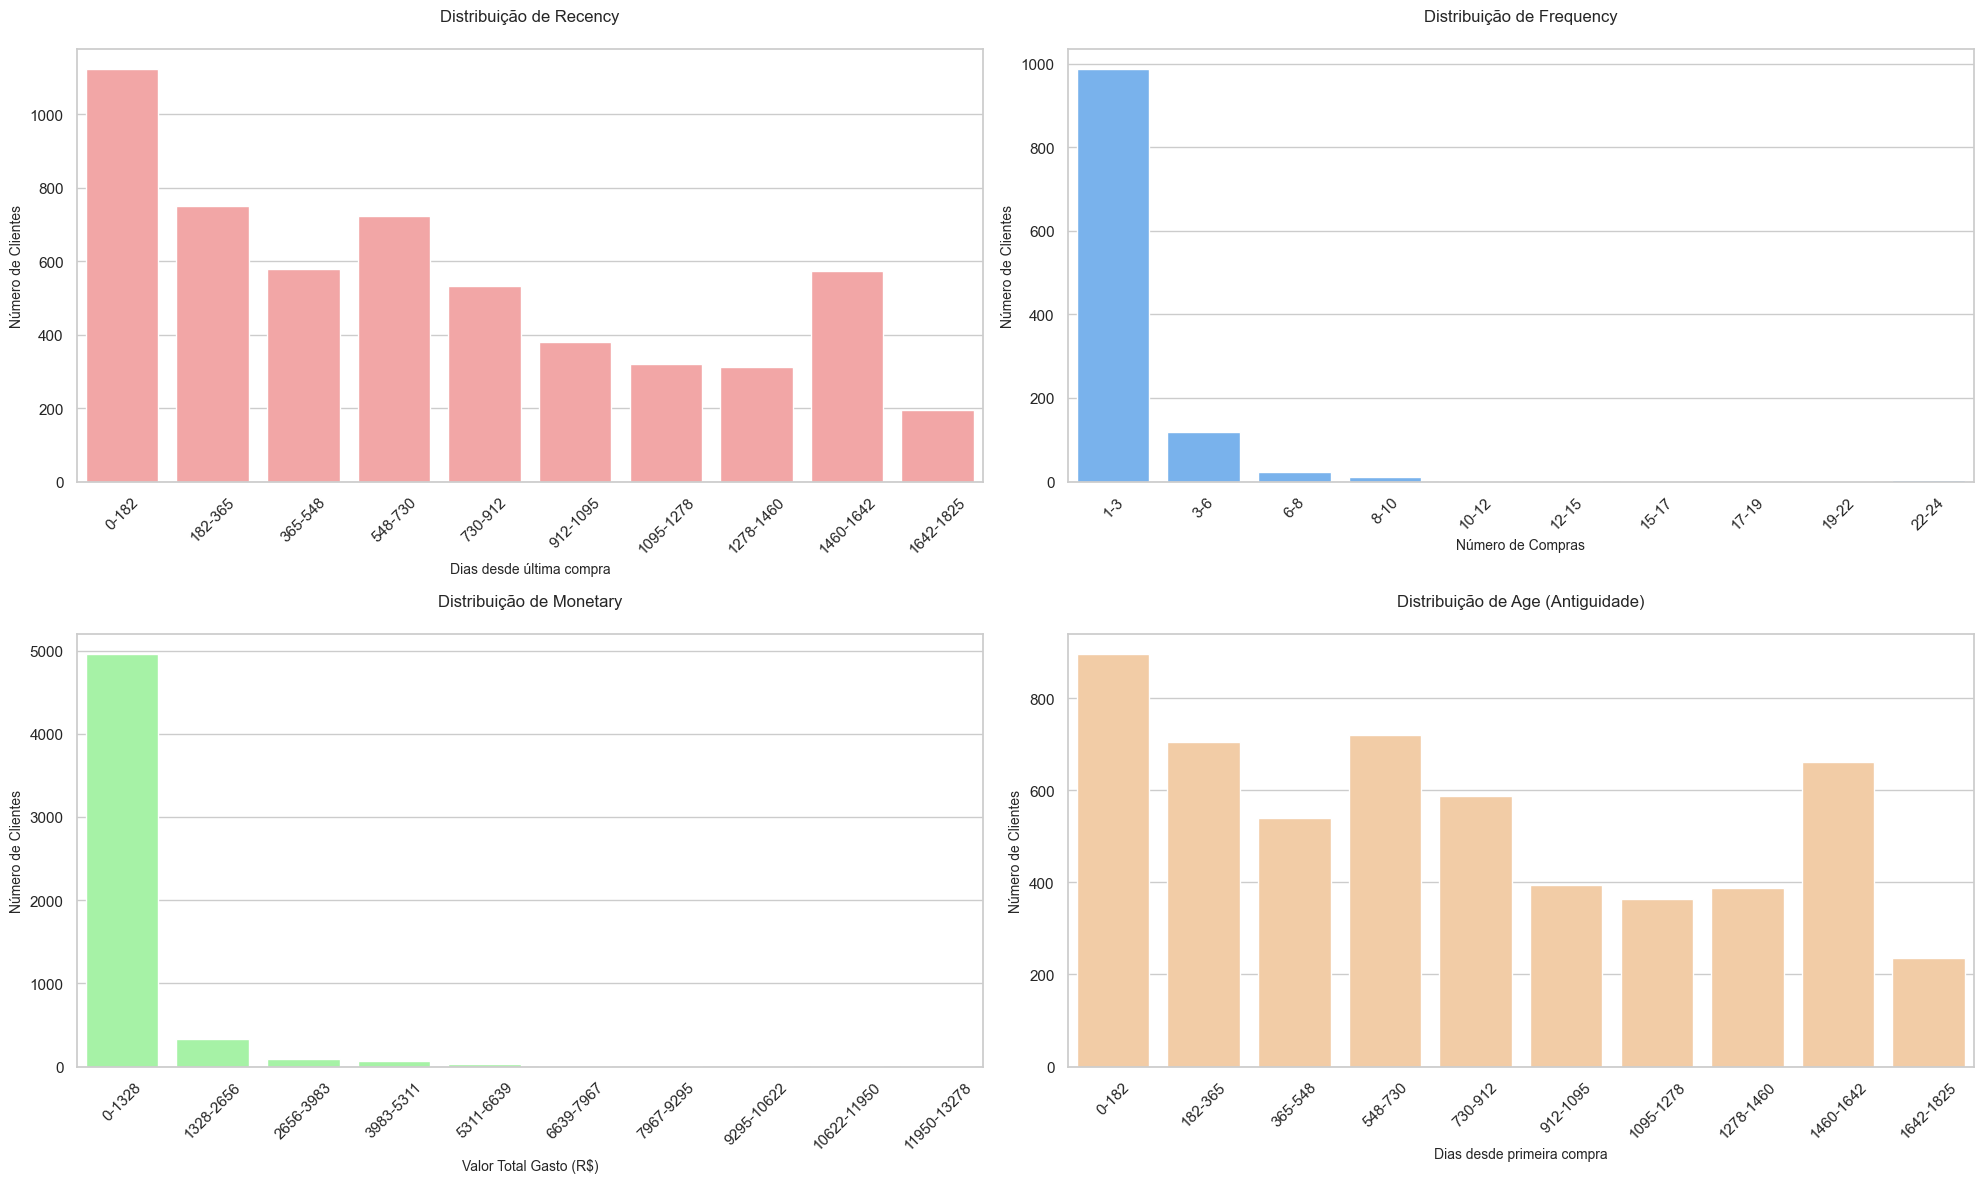


Distribuição de clientes por faixa:

Recency (dias):
R_range
0-182        1122
182-365       751
365-548       578
548-730       722
730-912       532
912-1095      380
1095-1278     321
1278-1460     312
1460-1642     574
1642-1825     194
Name: count, dtype: int64

Frequency (compras):
F_range
1-3      986
3-6      118
6-8       23
8-10      10
10-12      1
12-15      2
15-17      2
17-19      0
19-22      1
22-24      3
Name: count, dtype: int64

Monetary (R$):
M_range
0-1328         4954
1328-2656       329
2656-3983        93
3983-5311        61
5311-6639        28
6639-7967        12
7967-9295         4
9295-10622        2
10622-11950       3
11950-13278       2
Name: count, dtype: int64

Age (dias desde primeira compra):
A_range
0-182        895
182-365      705
365-548      539
548-730      720
730-912      587
912-1095     394
1095-1278    364
1278-1460    387
1460-1642    662
1642-1825    235
Name: count, dtype: int64


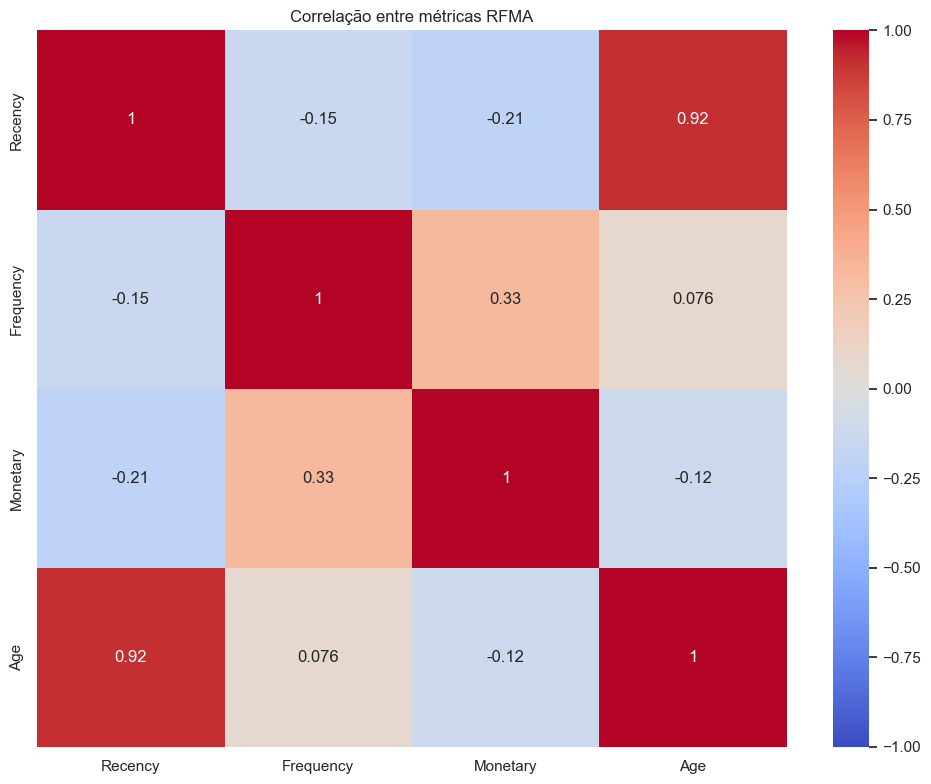

In [260]:
# Configuração básica do seaborn
sns.set(style="whitegrid")

# Criar bins e labels para cada métrica
def create_range_labels(data, bins):
    labels = []
    for i in range(len(bins)-1):
        labels.append(f'{bins[i]:.0f}-{bins[i+1]:.0f}')
    return labels

# Definir uma paleta de cores atraente
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Recency
r_bins = np.linspace(rfma['Recency'].min(), rfma['Recency'].max(), 11)
r_labels = create_range_labels(rfma['Recency'], r_bins)
rfma['R_range'] = pd.cut(rfma['Recency'], bins=r_bins, labels=r_labels)

# Frequency
f_bins = np.linspace(rfma['Frequency'].min(), rfma['Frequency'].max(), 11)
f_labels = create_range_labels(rfma['Frequency'], f_bins)
rfma['F_range'] = pd.cut(rfma['Frequency'], bins=f_bins, labels=f_labels)

# Monetary
m_bins = np.linspace(rfma['Monetary'].min(), rfma['Monetary'].max(), 11)
m_labels = create_range_labels(rfma['Monetary'], m_bins)
rfma['M_range'] = pd.cut(rfma['Monetary'], bins=m_bins, labels=m_labels)

# Age (Antiguidade)
a_bins = np.linspace(rfma['Age'].min(), rfma['Age'].max(), 11)
a_labels = create_range_labels(rfma['Age'], a_bins)
rfma['A_range'] = pd.cut(rfma['Age'], bins=a_bins, labels=a_labels)

# Criar gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color=colors[0])
axes[0,0].set_title('Distribuição de Recency', fontsize=12, pad=20)
axes[0,0].set_xlabel('Dias desde última compra', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color=colors[1])
axes[0,1].set_title('Distribuição de Frequency', fontsize=12, pad=20)
axes[0,1].set_xlabel('Número de Compras', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color=colors[2])
axes[1,0].set_title('Distribuição de Monetary', fontsize=12, pad=20)
axes[1,0].set_xlabel('Valor Total Gasto (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color=colors[3])
axes[1,1].set_title('Distribuição de Age (Antiguidade)', fontsize=12, pad=20)
axes[1,1].set_xlabel('Dias desde primeira compra', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Ajustar o layout
plt.tight_layout()
plt.show()

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (dias):")
print(r_counts)
print("\nFrequency (compras):")
print(f_counts)
print("\nMonetary (R$):")
print(m_counts)
print("\nAge (dias desde primeira compra):")
print(a_counts)

# Análises adicionais de correlação
correlation_matrix = rfma[['Recency', 'Frequency', 'Monetary', 'Age']].corr()

# Plotar mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlação entre métricas RFMA')
plt.tight_layout()
plt.show()

#### RFMA - ANÁLISE DE CLIENTES POR DECIS

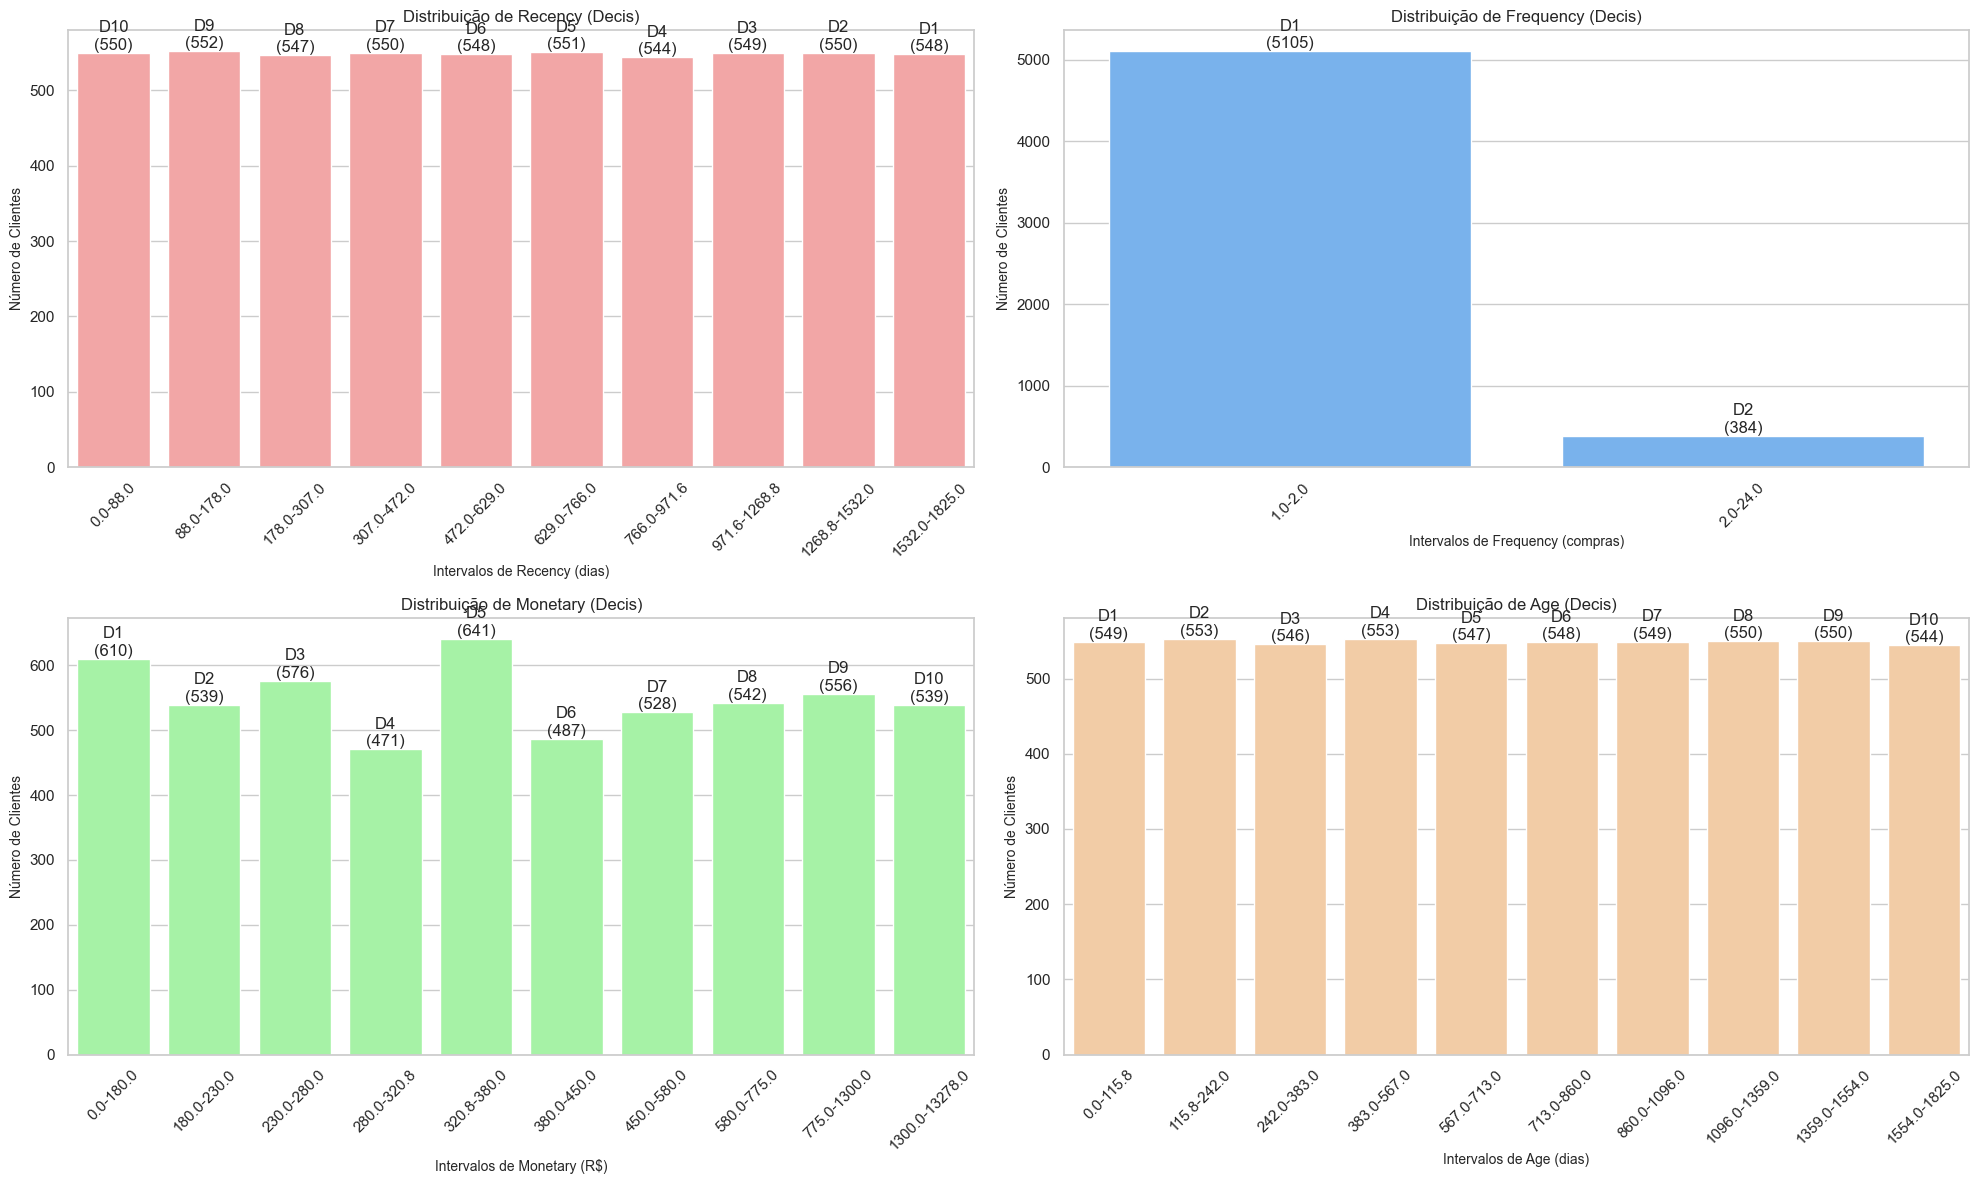


Exemplo dos primeiros registros com decis:
   Recency R_decil  Frequency F_decil  Monetary M_decil     Age A_decil
0    397.0       7        1.0       1     330.0       5   397.0       4
1   1321.0       2        1.0       1     250.0       3  1321.0       8
2    444.0       7        1.0       1     440.0       6   444.0       4
3     20.0      10        1.0       1     750.0       8    20.0       1
4    964.0       4        1.0       1     280.0       3   964.0       7

Distribuição de clientes por faixa:

Recency (Ranges):
R_range
0.0-88.0         550
88.0-178.0       552
178.0-307.0      547
307.0-472.0      550
472.0-629.0      548
629.0-766.0      551
766.0-971.6      544
971.6-1268.8     549
1268.8-1532.0    550
1532.0-1825.0    548
Name: count, dtype: int64

Frequency (Ranges):
F_range
1.0-2.0     5105
2.0-24.0     384
Name: count, dtype: int64

Monetary (Ranges):
M_range
0.0-180.0         610
180.0-230.0       539
230.0-280.0       576
280.0-320.8       471
320.8-380.0       6

In [261]:
# Converter as colunas para float (caso estejam em decimal.Decimal)
for col in ['Recency', 'Frequency', 'Monetary', 'Age']:
    rfma[col] = rfma[col].astype(float)

# Criar decis para cada métrica RFMA
# Primeiro vamos obter os bins para cada métrica
_, r_bins = pd.qcut(rfma['Recency'], q=10, duplicates='drop', retbins=True)
_, f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates='drop', retbins=True)
_, m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates='drop', retbins=True)
_, a_bins = pd.qcut(rfma['Age'], q=10, duplicates='drop', retbins=True)

# Agora criar os labels com o número correto de categorias
r_labels = list(range(len(r_bins)-1, 0, -1))  # Ordem inversa para Recency
f_labels = list(range(1, len(f_bins)))  # Ordem normal para os demais
m_labels = list(range(1, len(m_bins)))
a_labels = list(range(1, len(a_bins)))

# Aplicar os decis
rfma['R_decil'] = pd.qcut(rfma['Recency'], q=10, labels=r_labels, duplicates='drop')
rfma['F_decil'] = pd.qcut(rfma['Frequency'], q=10, labels=f_labels, duplicates='drop')
rfma['M_decil'] = pd.qcut(rfma['Monetary'], q=10, labels=m_labels, duplicates='drop')
rfma['A_decil'] = pd.qcut(rfma['Age'], q=10, labels=a_labels, duplicates='drop')

# Criar ranges para visualização
r_bins = pd.qcut(rfma['Recency'], q=10, duplicates="drop", retbins=True)[1]
rfma['R_range'] = pd.cut(
    rfma['Recency'], 
    bins=r_bins, 
    labels=[f"{r_bins[i]:.1f}-{r_bins[i+1]:.1f}" for i in range(len(r_bins)-1)], 
    include_lowest=True
)

f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates="drop", retbins=True)[1]
rfma['F_range'] = pd.cut(
    rfma['Frequency'], 
    bins=f_bins, 
    labels=[f"{f_bins[i]:.1f}-{f_bins[i+1]:.1f}" for i in range(len(f_bins)-1)], 
    include_lowest=True
)

m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates="drop", retbins=True)[1]
rfma['M_range'] = pd.cut(
    rfma['Monetary'], 
    bins=m_bins, 
    labels=[f"{m_bins[i]:.1f}-{m_bins[i+1]:.1f}" for i in range(len(m_bins)-1)], 
    include_lowest=True
)

a_bins = pd.qcut(rfma['Age'], q=10, duplicates="drop", retbins=True)[1]
rfma['A_range'] = pd.cut(
    rfma['Age'], 
    bins=a_bins, 
    labels=[f"{a_bins[i]:.1f}-{a_bins[i+1]:.1f}" for i in range(len(a_bins)-1)], 
    include_lowest=True
)

# Configurar estilo do gráfico
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color='#FF9999')
axes[0,0].set_title('Distribuição de Recency (Decis)', fontsize=12)
axes[0,0].set_xlabel('Intervalos de Recency (dias)', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Recency
for i, v in enumerate(r_counts):
    decil = 10 - i  # Decil invertido para Recency
    axes[0,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color='#66B2FF')
axes[0,1].set_title('Distribuição de Frequency (Decis)', fontsize=12)
axes[0,1].set_xlabel('Intervalos de Frequency (compras)', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Frequency
for i, v in enumerate(f_counts):
    decil = i + 1
    axes[0,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color='#99FF99')
axes[1,0].set_title('Distribuição de Monetary (Decis)', fontsize=12)
axes[1,0].set_xlabel('Intervalos de Monetary (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Monetary
for i, v in enumerate(m_counts):
    decil = i + 1
    axes[1,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color='#FFCC99')
axes[1,1].set_title('Distribuição de Age (Decis)', fontsize=12)
axes[1,1].set_xlabel('Intervalos de Age (dias)', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Age
for i, v in enumerate(a_counts):
    decil = i + 1
    axes[1,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Imprimir exemplo dos primeiros registros com os decis
print("\nExemplo dos primeiros registros com decis:")
print(rfma[['Recency', 'R_decil', 'Frequency', 'F_decil', 
            'Monetary', 'M_decil', 'Age', 'A_decil']].head())

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (Ranges):")
print(r_counts)
print("\nFrequency (Ranges):")
print(f_counts)
print("\nMonetary (Ranges):")
print(m_counts)
print("\nAge (Ranges):")
print(a_counts)

#### RFMA - SEGMENTAÇÃO BASEADA EM REGRAS

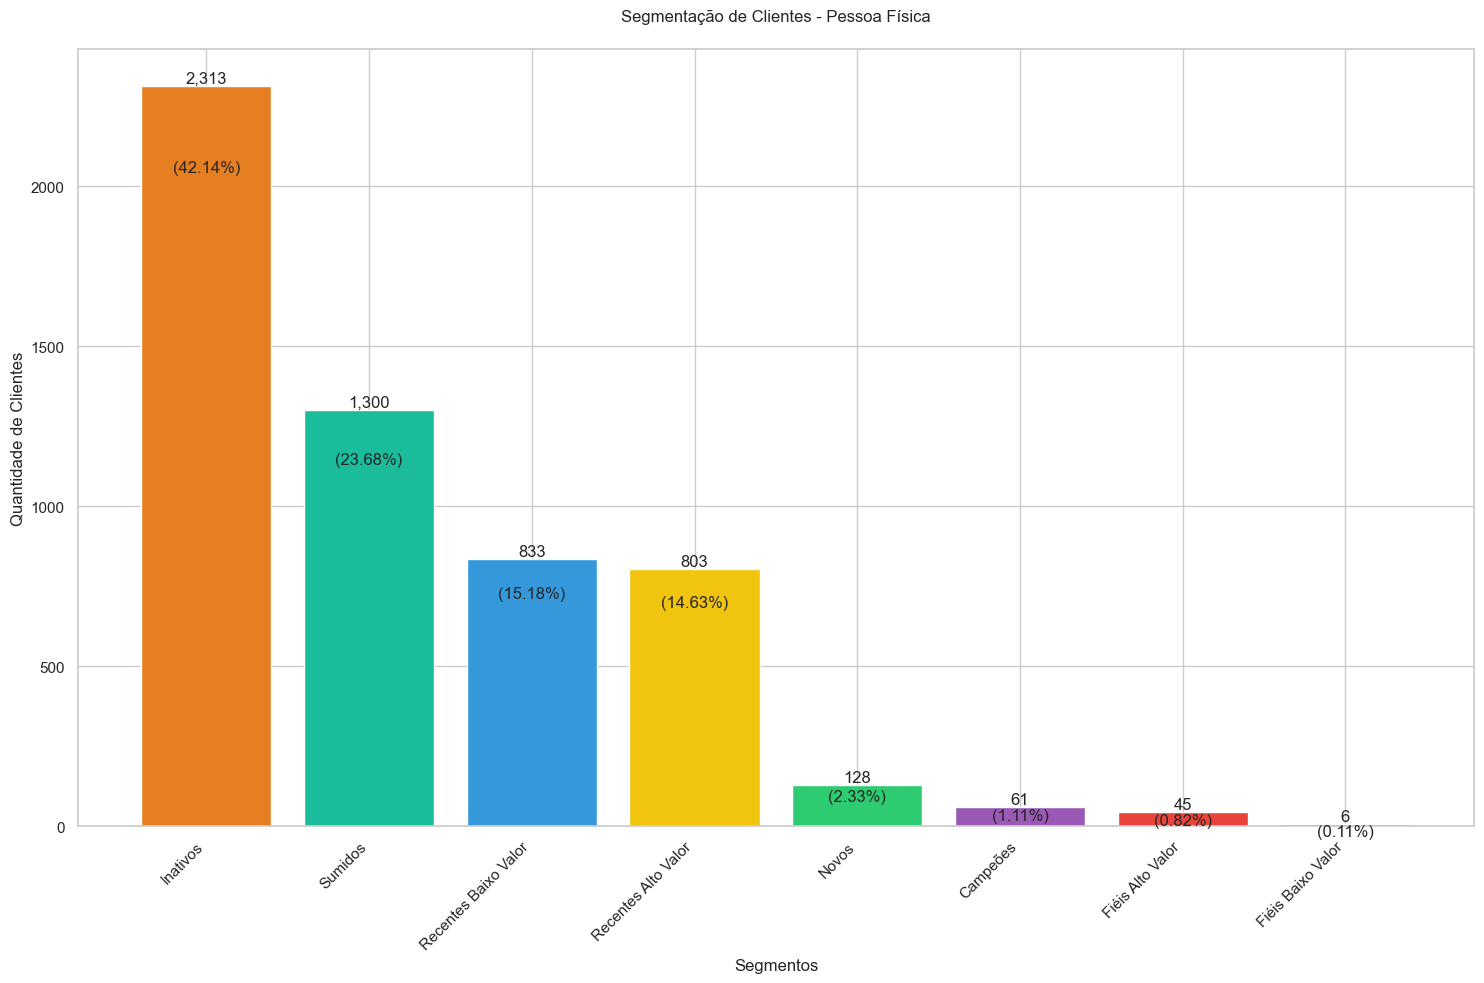


Análise Detalhada por Segmento:
                      Quantidade Clientes  Média Recency (dias)  \
Segmento                                                          
Inativos                             2313               1232.65   
Sumidos                              1300                562.94   
Recentes Baixo Valor                  833                192.59   
Recentes Alto Valor                   803                163.77   
Novos                                 128                 14.97   
Campeões                               61                 69.31   
Fiéis Alto Valor                       45                195.20   
Fiéis Baixo Valor                       6                169.50   

                      Média Frequency  Média Monetary (R$)  Média Age (dias)  
Segmento                                                                      
Inativos                         1.21               494.85           1260.27  
Sumidos                          1.38               584.63 

In [262]:
def segment_customers(df):
    """
    Segmenta clientes com base em regras atualizadas, de acordo com a análise da distribuição por faixa.
    
    Parâmetros:
    - Recency: dias desde a última compra
    - Age: dias desde a primeira compra (antiguidade)
    - Frequency: número de compras
    - Monetary: valor médio das compras
    """
    # Criar cópia do dataframe
    df_seg = df.copy()
    
    # Definir condições de forma mutuamente exclusiva

    cond_novos = (df_seg['Recency'] <= 30) & (df_seg['Age'] <= 30) # compraram no mês anterior
    
    cond_campeoes = (df_seg['Recency'] <= 180) & \
                    (df_seg['Frequency'] >= 3) & (df_seg['M_decil'] == 10) # clientes que compraram nos últimos 6 meses e possuem valor monetário muito acima da média
                    
    cond_fieis_baixo_valor = (df_seg['Recency'] <= 365) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 3) & (df_seg['M_decil'] <= 7) # clientes há mais de 2 anos que compraram no último ano e possuem valor monetário menor ou igual a média
    
    cond_fieis_alto_valor = (df_seg['Recency'] <= 365) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 3) & (df_seg['M_decil'] > 7) # clientes há mais de 2 anos que compraram no último ano e possuem valor monetário abaixo da média
                 
    cond_recentes_alto = (df_seg['Recency'] <= 365) & \
                         (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] >= 6) # clientes que compraram nos últimos 6 meses, com idade de 1 ano e possui valor monetário acima da média
                         
    cond_recentes_baixo = (df_seg['Recency'] <= 365) & \
                          (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] < 6) # clientes que compraram nos últimos 6 meses, com idade de 1 ano e possui valor monetário menor ou igual da média
    
    # Clientes menos ativos
    cond_sumidos = (df_seg['Recency'] >= 365) & (df_seg['Recency'] < 730) # última compra entre 1 a 2 anos
    cond_inativos = (df_seg['Recency'] >= 730) # sem comprar faz 2 anos
    
    # Lista de condições e respectivos rótulos
    conditions = [
        cond_novos,
        cond_campeoes,
        cond_fieis_baixo_valor,
        cond_fieis_alto_valor,
        cond_recentes_alto,
        cond_recentes_baixo,
        cond_sumidos,
        cond_inativos
    ]
    
    labels = [
        'Novos',
        'Campeões',
        'Fiéis Baixo Valor',
        'Fiéis Alto Valor',
        'Recentes Alto Valor',
        'Recentes Baixo Valor',
        'Sumidos',
        'Inativos'
    ]
    
    # Aplicar segmentação
    df_seg['Segmento'] = np.select(conditions, labels, default='Não Classificado')
    
    # Definir cores para cada segmento
    cores_segmento = {
        'Novos': '#2ecc71',              # Verde
        'Campeões': '#9b59b6',           # Roxo
        'Fiéis Baixo Valor': '#e74c3c',  # Vermelho
        'Fiéis Alto Valor' : '#e7443c',  
        'Recentes Alto Valor': '#f1c40f', # Amarelo
        'Recentes Baixo Valor': '#3498db',# Azul
        'Sumidos': '#1abc9c',             # Turquesa
        'Inativos': '#e67e22'             # Laranja
    }
    
    # Agregar dados para análise dos segmentos
    analise_segmentos = df_seg.groupby('Segmento').agg({
        'id_cliente': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Age': 'mean'
    }).round(2)
    
    analise_segmentos.columns = [
        'Quantidade Clientes',
        'Média Recency (dias)',
        'Média Frequency',
        'Média Monetary (R$)',
        'Média Age (dias)'
    ]
    
    # Ordenar por quantidade de clientes
    analise_segmentos = analise_segmentos.sort_values('Quantidade Clientes', ascending=False)
    
    # Visualização dos segmentos
    plt.figure(figsize=(15, 10))
    total_clientes = analise_segmentos['Quantidade Clientes'].sum()
    
    bars = plt.bar(
        analise_segmentos.index,
        analise_segmentos['Quantidade Clientes'],
        color=[cores_segmento.get(seg, '#95a5a6') for seg in analise_segmentos.index]
    )
    
    plt.title('Segmentação de Clientes - Pessoa Física', pad=20)
    plt.xlabel('Segmentos')
    plt.ylabel('Quantidade de Clientes')
    plt.xticks(rotation=45, ha='right')
    
    # Adicionar valores e porcentagens nas barras
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_clientes) * 100
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom'
        )
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height * 0.9,
            f'({percentage:.2f}%)',
            ha='center',
            va='top'
        )
    
    plt.tight_layout()
    plt.show()
    
    return df_seg, analise_segmentos

# Usar a função
rfma_segmentado, analise = segment_customers(rfma)

# Salvar resultados
# rfma_segmentado.to_excel('rfma_segmentado_regras.xlsx', index=False)
# print("\nResultados salvos em 'rfma_segmentado_regras.xlsx'")

# Exibir análise
print("\nAnálise Detalhada por Segmento:")
print("=" * 120)
print(analise)

#### Preparando dados para o Dashboard da BIBI

In [263]:
rfma_segmentado = rfma_segmentado.merge(df_clientes_PF[['id_cliente', 'nome', 'cpf']], on='id_cliente', how='left')
rfma_segmentado = rfma_segmentado.merge(df_clientes[['id_cliente', 'email', 'telefone']], on='id_cliente', how='left')
print(rfma_segmentado.columns)
#Arquivo usado para o dash de segmentação
rfma_segmentado.to_csv('analytics_cliente_BIBI_PF.csv', index=False)

Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'Age', 'R_range',
       'F_range', 'M_range', 'A_range', 'R_decil', 'F_decil', 'M_decil',
       'A_decil', 'Segmento', 'nome', 'cpf', 'email', 'telefone'],
      dtype='object')


#### PREDIÇÃO DE COMPRAS POR CLIENTE NOS PRÓXIMOS 30 DIAS

Optimization terminated successfully.
         Current function value: -6.442919
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17

Parâmetros do Modelo:
<lifetimes.BetaGeoFitter: fitted with 160 subjects, a: 0.33, alpha: 121.68, b: 2.14, r: 1.24>

Estatísticas das Previsões:
count    156.000000
mean       0.143629
std        0.200072
min        0.000242
25%        0.049698
50%        0.089843
75%        0.154134
max        1.535341
Name: predicted_purchases_30d, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lifetimes/fitters/__init__.py:101: OptimizeWarning: Unknown solver options: iterative_fitting
  output = minimize(


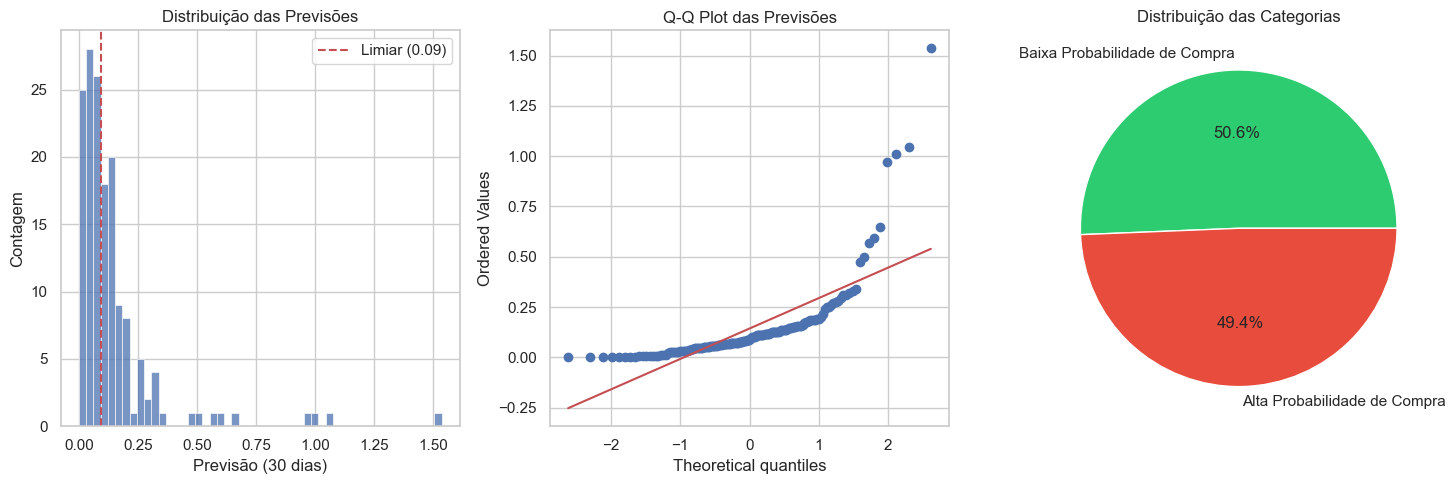


Análise por Categoria de Previsão:
                              Frequency              Recency        Monetary  \
                                   mean median count    mean median     mean   
categoria_previsao                                                             
Alta Probabilidade de Compra       6.12    5.0    77  116.38  106.0  2456.19   
Baixa Probabilidade de Compra      4.57    4.0    79  561.32  533.0  1911.13   

                                      predicted_purchases_30d              \
                               median                    mean median  min   
categoria_previsao                                                          
Alta Probabilidade de Compra   1555.0                    0.24   0.16  0.1   
Baixa Probabilidade de Compra  1409.0                    0.05   0.05  0.0   

                                     
                                max  
categoria_previsao                   
Alta Probabilidade de Compra   1.54  
Baixa Probabilidade de Co

In [264]:
# Pré-processamento para o modelo BG/NBD
rfma = rfma_segmentado.copy()

# Limpeza e tratamento dos dados
rfma = rfma[rfma['Frequency'] > 3]

# Ajustar os valores para evitar problemas numéricos
rfma['frequency_adjusted'] = rfma['Frequency'] - 1
rfma['recency_bg'] = (rfma['Age'] - rfma['Recency']).clip(lower=1)  # Garantir valores positivos
rfma['T'] = rfma['Age'].clip(lower=1)  # Garantir valores positivos

# Remover outliers extremos
for col in ['frequency_adjusted', 'recency_bg', 'T']:
    Q1 = rfma[col].quantile(0.01)
    Q3 = rfma[col].quantile(0.99)
    IQR = Q3 - Q1
    rfma = rfma[
        (rfma[col] >= Q1 - 1.5 * IQR) &
        (rfma[col] <= Q3 + 1.5 * IQR)
    ]

# Ajuste do Modelo BG/NBD com parâmetros para melhor convergência
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Aumentar penalizador
bgf.fit(
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T'],
    iterative_fitting=2,          # Reduzir número de iterações
    tol=1e-4,                     # Aumentar tolerância
    initial_params=None,          # Permitir estimativa automática
    verbose=True                  # Mostrar progresso
)

# Calcular previsões para 30 dias
rfma['predicted_purchases_30d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30,
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T']
)

# Remover previsões extremas ou inválidas
rfma = rfma[rfma['predicted_purchases_30d'].between(
    rfma['predicted_purchases_30d'].quantile(0.01),
    rfma['predicted_purchases_30d'].quantile(0.99)
)]

# Imprimir parâmetros do modelo
print("\nParâmetros do Modelo:")
print(bgf)
print("\nEstatísticas das Previsões:")
print(rfma['predicted_purchases_30d'].describe())

# Definir limiar usando método mais robusto
limiar = rfma['predicted_purchases_30d'].median() + \
         rfma['predicted_purchases_30d'].std() * 0.01

# Classificar clientes
rfma['categoria_previsao'] = np.where(
    rfma['predicted_purchases_30d'] >= limiar,
    'Alta Probabilidade de Compra',
    'Baixa Probabilidade de Compra'
)

# Visualizações
plt.figure(figsize=(15, 5))

# 1. Distribuição das Previsões
plt.subplot(1, 3, 1)
sns.histplot(data=rfma, x='predicted_purchases_30d', bins=50)
plt.axvline(x=limiar, color='r', linestyle='--', label=f'Limiar ({limiar:.2f})')
plt.title('Distribuição das Previsões')
plt.xlabel('Previsão (30 dias)')
plt.ylabel('Contagem')
plt.legend()

# 2. QQ-Plot para verificar normalidade
plt.subplot(1, 3, 2)
from scipy.stats import probplot
probplot(rfma['predicted_purchases_30d'], dist="norm", plot=plt)
plt.title('Q-Q Plot das Previsões')

# 3. Contagem por Categoria
plt.subplot(1, 3, 3)
contagem = rfma['categoria_previsao'].value_counts()
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'])
plt.title('Distribuição das Categorias')

plt.tight_layout()
plt.show()

# Análise por categoria
print("\nAnálise por Categoria de Previsão:")
analise_categoria = rfma.groupby('categoria_previsao').agg({
    'Frequency': ['mean', 'median', 'count'],
    'Recency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'predicted_purchases_30d': ['mean', 'median', 'min', 'max']
}).round(2)

print(analise_categoria)

# Validação das previsões
print("\nValidação do Modelo:")
print(f"Média de transações previstas: {rfma['predicted_purchases_30d'].mean():.2f}")
print(f"Mediana de transações previstas: {rfma['predicted_purchases_30d'].median():.2f}")
print(f"% de clientes com alta probabilidade: {(rfma['categoria_previsao'] == 'Alta Probabilidade de Compra').mean()*100:.1f}%")

# Salvar resultados
rfma.to_excel('rfma_previsoes_ajustado.xlsx', index=False)
print("\nResultados salvos em 'rfma_previsoes_ajustado.xlsx'")

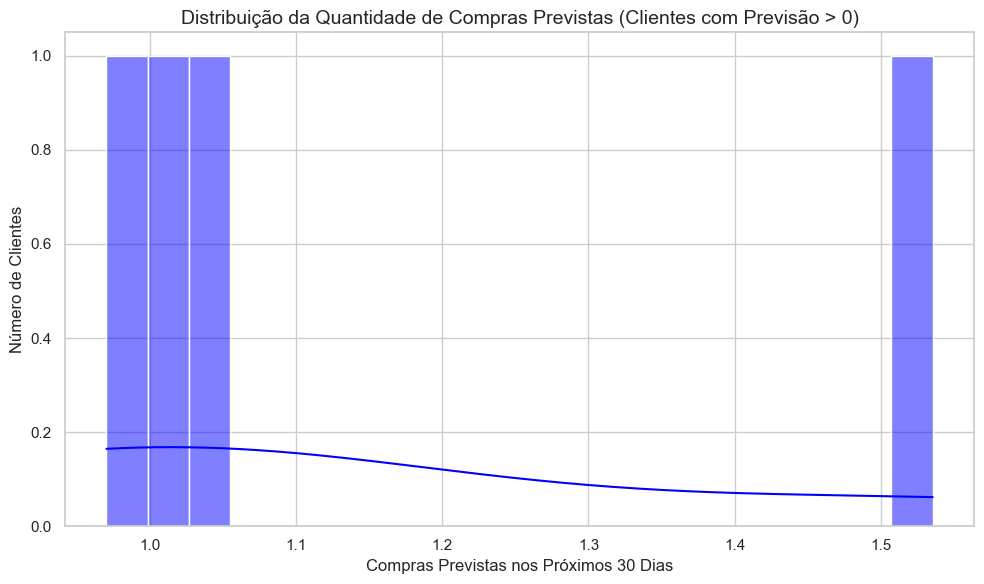

In [265]:
# Filtrar os clientes com previsão de compras > 0 utilizando .loc para garantir que uma Series seja retornada
dados = rfma.loc[rfma['predicted_purchases_30d'] > 0.8, 'predicted_purchases_30d']
plt.figure(figsize=(10, 6))
# Se o parâmetro edgecolor continuar causando problemas, remova-o:
sns.histplot(dados, bins=20, kde=True, color='blue')
# Caso deseje usar edgecolor, tente:
# sns.histplot(dados, bins=20, kde=True, color='blue', edgecolor='k')
plt.title('Distribuição da Quantidade de Compras Previstas (Clientes com Previsão > 0)', fontsize=14)
plt.xlabel('Compras Previstas nos Próximos 30 Dias', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.tight_layout()
plt.show()